In [1]:
import numpy
from matplotlib import pyplot
%matplotlib inline

In [2]:
class Panel:
    def __init__(self,xa,ya,xb,yb):
        self.xa,self.ya = xa,ya
        self.xb,self.yb = xb,yb
        self.xc,self.yc = (xa+xb)/2, (ya+yb)/2
        self.length = numpy.sqrt((xb-xa)**2+(yb-ya)**2)
        if xb-xa <= 0.:
            self.beta = numpy.arccos((yb-ya)/self.length)
        elif xb-xa > 0.:
            self.beta = numpy.pi + numpy.arccos(-(yb-ya)/self.length)
            
        self.n=[numpy.cos(self.beta),numpy.sin(self.beta)]
        self.t=[-numpy.sin(self.beta),numpy.cos(self.beta)]
        self.sigma = 1
        self.vt = 0
        self.cp = 0
        self.kappa = 1

In [3]:
N_panels = 38                    # number of panels desired

T = 0.12
H = 0.02
c = 1
a = c/4
r = (0.25+T/(3*numpy.sqrt(3)))                      # circle radius
zeta_c = -4*a/(3*numpy.sqrt(3))*T + 1j*2*a*H        # circle center
theta = numpy.linspace(0, 2*numpy.pi, N_panels+1)   # theta endpoints of panels
zeta = r*numpy.exp(1j*theta)                       # endpoints of circle surface panels
z_ends = (zeta+zeta_c) + a**2/(zeta+zeta_c)        # endpoints of airfoil surface panels
x_ends,  y_ends = z_ends.real, z_ends.imag

# define the panels
panels = numpy.empty(N_panels, dtype=object)
for i in range(N_panels):
    panels[i] = Panel(x_ends[i], y_ends[i], x_ends[i+1], y_ends[i+1])

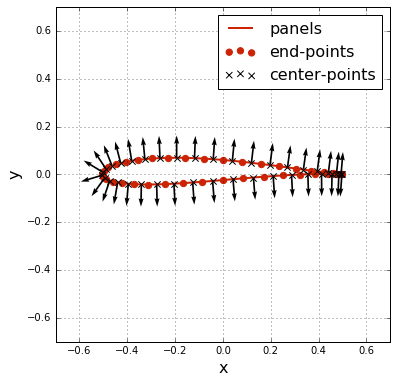

In [4]:
pyplot.figure(figsize=(6, 6))
pyplot.grid(True)
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('y', fontsize=16)
pyplot.plot(x_ends, y_ends, color='#CD2305', linestyle='-', linewidth=2)
pyplot.scatter([p.xa for p in panels], [p.ya for p in panels], color='#CD2305', s=40)
pyplot.scatter([p.xc for p in panels], [p.yc for p in panels], color='k', marker='x', s=40, zorder=3)
pyplot.quiver([p.xc for p in panels], [p.yc for p in panels], [p.n[0] for p in panels], [p.n[1] for p in panels],
              scale=15, width=0.005)
pyplot.legend(['panels', 'end-points', 'center-points'], 
           loc='best', prop={'size':16})
pyplot.axis('equal')
pyplot.ylim(-0.5,0.5)
pyplot.xlim(-0.7,0.7);

In [5]:
u_inf = 1.0
alpha = numpy.radians(2.0)

In [6]:
def panel_doub_vel(p,x,y): 
    x_p = numpy.sin(p.beta)*(x-p.xb) - numpy.cos(p.beta)*(y-p.yb)
    y_p = numpy.cos(p.beta)*(x-p.xb) + numpy.sin(p.beta)*(y-p.yb)
    
    u_p = -p.kappa/(2*numpy.pi)*( (y_p/(x_p**2+y_p**2)) - (y_p/((x_p-p.length)**2+y_p**2)) )
    v_p = p.kappa/(2*numpy.pi)*( (x_p/(x_p**2+y_p**2)) - ((x_p-p.length)/((x_p-p.length)**2+y_p**2)) )
    
    u = numpy.sin(p.beta)*u_p + numpy.cos(p.beta)*v_p
    v = -numpy.cos(p.beta)*u_p + numpy.sin(p.beta)*v_p
    return u,v

def panel_doub_vel_wake(p,x,y):
    x_p = numpy.sin(p.beta)*(x-p.xb) - numpy.cos(p.beta)*(y-p.yb)
    y_p = numpy.cos(p.beta)*(x-p.xb) + numpy.sin(p.beta)*(y-p.yb)
    
    u_p = -p.kappa/(2*numpy.pi)*(y_p/(x_p**2+y_p**2))
    v_p = p.kappa/(2*numpy.pi)*(x_p/(x_p**2+y_p**2))
    
    u = numpy.sin(p.beta)*u_p + numpy.cos(p.beta)*v_p
    v = -numpy.cos(p.beta)*u_p + numpy.sin(p.beta)*v_p
    return u,v

In [7]:
#normal comp
def build_matrix(panels):
    N=len(panels)
    A = numpy.empty((N,N),dtype=float)
    b = numpy.empty(len(panels),dtype=float)
    A[N-1,0]=1
    A[N-1,1:-2]=0
    A[N-1,-2:]=-1
    
    for i, p_i in enumerate(panels):
        for j,p_j in enumerate(panels):
            
            if i != j and i!=N-1 and j!=N-1:
                A[i,j] = numpy.dot(panel_doub_vel(p_j,p_i.xc,p_i.yc),p_i.n)
            elif i == j and i!=N-1 and j !=N-1:
                A[i,j] = 1.001*2/(numpy.pi*p_j.length)
            elif j == N-1 and i!=N-1:
                A[i,j]=numpy.dot(panel_doub_vel_wake(p_j,p_i.xc,p_i.yc),p_i.n)
        
        b[i:-1] = -numpy.dot(numpy.array([u_inf*numpy.cos(alpha),u_inf*numpy.sin(alpha)]),p_i.n)
        b[-1]=0
    return A,b

In [8]:
A,b = build_matrix(panels)
A,b

(array([[  54.83171605,  -22.54013307,   -2.69384844, ...,    5.27058259,
         -135.76645006,  -27.38846955],
        [  -5.45022311,   23.59163466,   -8.86553136, ...,   23.75083383,
          -35.76492251,   -6.33381019],
        [  -0.658064  ,   -4.41009283,   15.53347445, ...,  -18.5932823 ,
            1.79373729,   -2.69082142],
        ..., 
        [   1.31566434,   20.30369577,  -29.58041297, ...,   17.42480471,
           -4.63956192,    3.63968683],
        [  35.84474784,  -53.15529783,    4.25003893, ...,  -11.8636492 ,
           30.52804822,   10.60795789],
        [   1.        ,    0.        ,    0.        , ...,    0.        ,
           -1.        ,   -1.        ]]),
 array([-0.12030288, -0.14079449, -0.15583911, -0.16578538, -0.17031445,
        -0.16916771, -0.16218925, -0.14929859, -0.13044524, -0.10555008,
        -0.07442571, -0.03665473,  0.00861833,  0.06307923,  0.13005453,
         0.21635319,  0.33685124,  0.52582417,  0.83558868,  0.96710131,
        

In [9]:
kappa = numpy.linalg.solve(A,b)
kappa

array([ -5.11707762e-01,  -5.09603892e-01,  -5.04997580e-01,
        -4.37689586e-01,  -4.60197449e-01,  -4.48533195e-01,
        -4.12006664e-01,  -3.57745231e-01,  -2.91397907e-01,
        -2.17099559e-01,  -1.38134935e-01,  -5.74513498e-02,
         2.22028024e-02,   9.82968808e-02,   1.68564092e-01,
         2.31049538e-01,   2.84170202e-01,   3.26817026e-01,
         3.58473564e-01,   3.77846957e-01,   3.81267409e-01,
         3.70880479e-01,   3.49086674e-01,   3.17471919e-01,
         2.77715987e-01,   2.31786634e-01,   1.81960778e-01,
         1.30812997e-01,   8.12151813e-02,   3.63814198e-02,
        -1.24199281e-05,  -2.36966588e-02,  -2.98987046e-02,
        -1.26812768e-02,   4.89822045e-02,   2.62901759e-03,
        -1.67626438e-03,  -5.10031498e-01])

In [10]:
for i, panel in enumerate(panels):
    panel.kappa = kappa[i]

In [11]:
#tangential comp
def build_matrix2(panels):
    N=len(panels)
    A2 = numpy.empty((N,N),dtype=float)
    b2 = numpy.empty(len(panels),dtype=float)
    A2[N-1,0]=1
    A2[N-1,1:-2]=0
    A2[N-1,-2:]=-1
    
    for i, p_i in enumerate(panels):
        for j,p_j in enumerate(panels):
            
            if i != j and i!=N-1 and j!=N-1:
                A2[i,j] = numpy.dot(panel_doub_vel(p_j,p_i.xc,p_i.yc),p_i.t)
            elif i == j and i!=N-1 and j !=N-1 and i!=0 and j!=0 and i!=N-2 and j!=N-2:
                A[i,j] = -1/2*(panels[i+1].kappa-panels[i-1].kappa)/numpy.sqrt(\
                        (panels[i+1].xc-panels[i-1].xc)**2+(panels[i+1].xc-panels[i-1].xc)**2)
                
                #A2[i,j] = -1/2*([p_j.kappa for p_j in panels][i+1]-[p_j.kappa for p_j in panels][i-1])\
                #/numpy.sqrt(([p_i.xc for p_i in panels][i+1]-[p_i.xc for p_i in panels][i-1])**2+\
                            #([p_i.xc for p_i in panels][i+1]-[p_i.xc for p_i in panels][i-1])**2)
            elif i ==0 and j==0:
                A2[i,j] = A2[1,1]
            elif i ==N-2 and j==N-2:
                A2[i,j] = A2[-2,-2]
            elif j == N-1 and i!=N-1:
                A2[i,j]=numpy.dot(panel_doub_vel_wake(p_j,p_i.xc,p_i.yc),p_i.t)
        
        b2[i:-1] = -numpy.dot(numpy.array([u_inf*numpy.cos(alpha),u_inf*numpy.sin(alpha)]),p_i.t)
        b2[-1]=0
    return A2,b2

In [12]:
A2,b2 = build_matrix2(panels)
A2, b2

(array([[  4.94065646e-324,   4.20306181e-002,  -1.17293717e-002, ...,
           5.55592455e-004,  -8.44638567e-003,  -1.33226763e-015],
        [ -3.09841690e-002,   4.94065646e-324,   1.68690546e-002, ...,
           3.26786872e-001,   2.09288061e-001,   3.08826703e-002],
        [ -4.45759032e-003,  -1.47570973e-002,   6.89997921e-310, ...,
          -6.68279821e-002,   2.91480390e-004,   1.92124680e-002],
        ..., 
        [ -3.32454162e-002,  -5.88404745e+000,   5.42277552e+000, ...,
           6.89998945e-310,   9.48322177e-005,   3.41009364e-002],
        [ -2.49642073e+000,   2.14048082e+000,   1.92480044e-001, ...,
           1.80819886e-004,   7.63918485e-313,   5.00717808e-002],
        [  1.00000000e+000,   0.00000000e+000,   0.00000000e+000, ...,
           0.00000000e+000,  -1.00000000e+000,  -1.00000000e+000]]),
 array([ 0.99273723,  0.99003884,  0.98778245,  0.98616186,  0.98538976,
         0.98558728,  0.98675967,  0.98879216,  0.99145552,  0.99441399,
         0

vt = numpy.dot(A2, kappa) + b2

for i, panel in enumerate(panels):
    panel.vt = vt[i]
    
for panel in panels:
    panel.cp = 1.0-(panel.vt/u_inf)**2

In [13]:
for i, p_i in enumerate(panels):
    vt = numpy.array([0])
    for j, p_j in enumerate(panels):
        if i != j:
            vt = vt + A2[i,j]
    vt = vt + b2[i]
    p_i.vt = float(vt)
    p_i.cp = 1.0 - (p_i.vt/u_inf)**2

In [14]:
[p.cp for p in panels]

[-0.011785958243974326,
 -1.4159457721745357,
 -3.6148572224571796,
 0.8818877450216003,
 0.22987653265395025,
 -0.06660446525325403,
 -0.22648596331751492,
 -0.33206384124346666,
 -0.4033671964233261,
 -0.4473863239570619,
 -0.4705923007111199,
 -0.47764215653347075,
 -0.4698749917929381,
 -0.44502387477235716,
 -0.3961953876522306,
 -0.3080343657684359,
 -0.14554873151448877,
 0.17733670346914787,
 0.8064882289959141,
 0.4472003387647172,
 -0.9949677882175711,
 -1.2444564640163813,
 -1.2197192093315565,
 -1.168110538337654,
 -1.1232501005256519,
 -1.0868286410325565,
 -1.0552576137596357,
 -1.0233638196474937,
 -0.9839985942843665,
 -0.9261238806260281,
 -0.8312835910391587,
 -0.6687763500993318,
 -0.3899662932449173,
 0.07764530977396467,
 -1.7343165187345067,
 -0.27247989372515025,
 -0.08802176551298713,
 1.0]

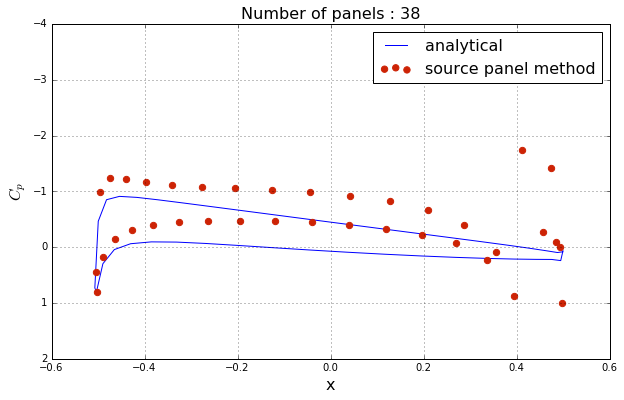

In [15]:
# create surface of airfoil for analytical solution
theta = numpy.linspace(0.01, 2*numpy.pi-0.01, 41)      # theta coordinates
zeta = r*numpy.exp(1j*theta)                  # circle coordinates
z = (zeta+zeta_c) + a**2/(zeta+zeta_c)        # airfoil coordinates

# flow parameters
al = 2.0*numpy.pi/180                          # angle of attack
kappaz = 2*numpy.pi*u_inf*r**2                   # doublet strength for circle with radius r
Gam = 4*numpy.pi*r*u_inf*numpy.sin(al+2*H)      # vortex strength

# compute the complex velocity on the surface
w = u_inf - kappaz/(2*numpy.pi)/zeta**2 + 1j*Gam/(2*numpy.pi)/zeta
zeta = zeta*numpy.exp(1j*al)

# Joukowski transformation
w = w/(1 - a**2/(zeta+zeta_c)**2)
cp_analytical = 1 - numpy.abs(w)**2/u_inf**2

# plots the surface pressure coefficient
pyplot.figure(figsize=(10, 6))
pyplot.grid(True)
pyplot.gca().invert_yaxis()
pyplot.xlabel('x', fontsize=16)
pyplot.ylabel('$C_p$', fontsize=16)
pyplot.plot(z.real, cp_analytical, color='b', linestyle='-', linewidth=1, zorder=1)
pyplot.scatter([p.xc for p in panels], [p.cp for p in panels], color='#CD2305', s=40, zorder=2)
pyplot.title('Number of panels : %d' % N_panels, fontsize=16)
pyplot.legend(['analytical', 'source panel method'], loc='best', prop={'size':16});